In [1]:

# Imporing required Packages/Modules
import os
import tensorflow as tf
import datetime
import numpy as np # For array-related manipulations
import pandas as pd # For DataFrame-related operations 
import matplotlib.pyplot as plt # Useful for graph plotting
import seaborn as sns # Another easy graph module
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Will be used for model evaluation
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, load_model # Base class for most Neural Networks
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.svm import SVC
from keras.layers import Input, Conv2D, MaxPool2D, Dense
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import time



In [2]:
data_dir = r'D:\New_Fourth_Year\projectDesignGit\pestInfestationSeverityLevel\Sugarcane Leaf Disease Split No Background'

Train_Data_Generator = ImageDataGenerator(featurewise_center=False,
                                    rescale=1./255,
                                    #rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

Test_Data_Generator = ImageDataGenerator(
                                    rescale=1./255)

train_set = Train_Data_Generator.flow_from_directory(directory=data_dir + '/train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True)


val_set = Test_Data_Generator.flow_from_directory(directory=data_dir + '/validation',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True)


Found 1845 images belonging to 5 classes.
Found 465 images belonging to 5 classes.


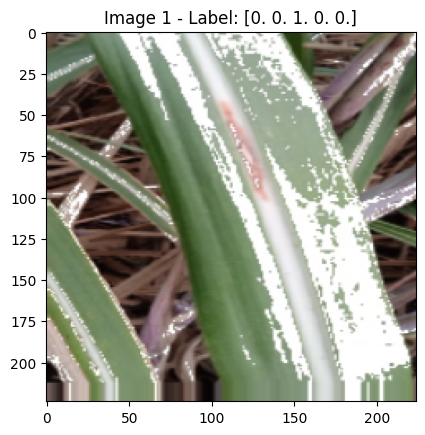

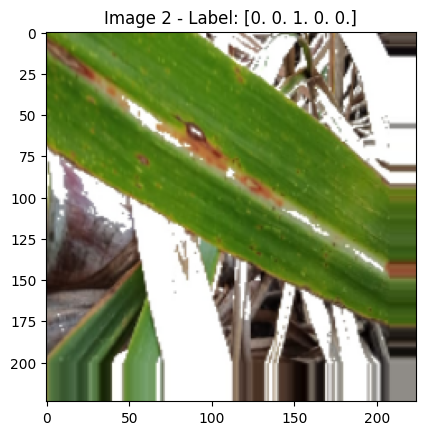

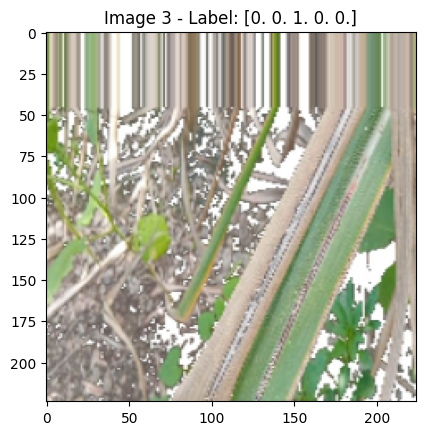

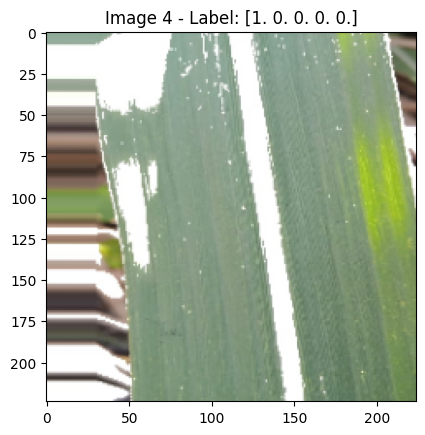

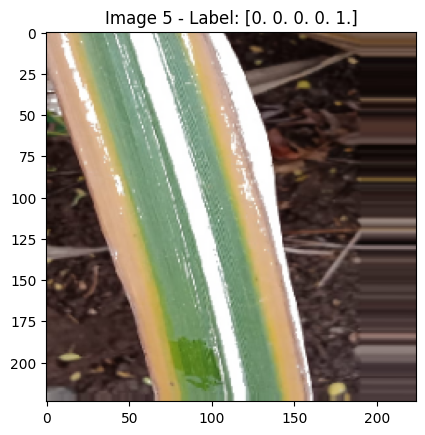

In [3]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(train_set)

# Output the first five images
for i in range(5):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


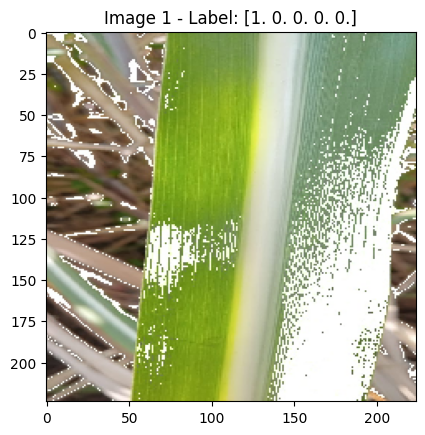

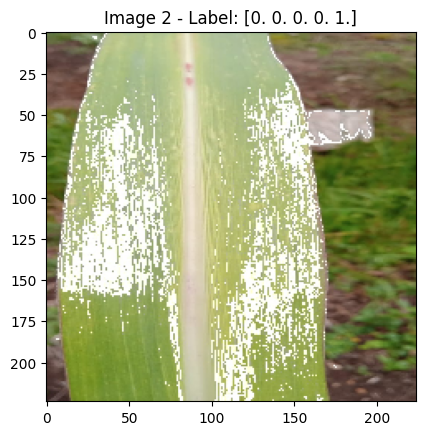

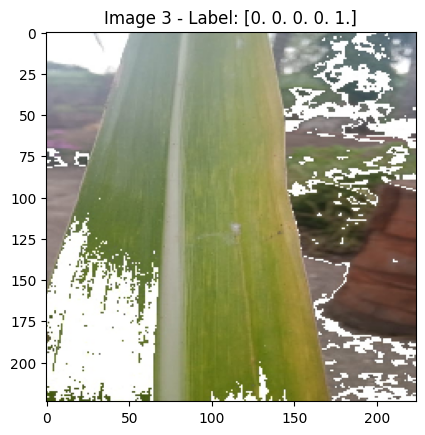

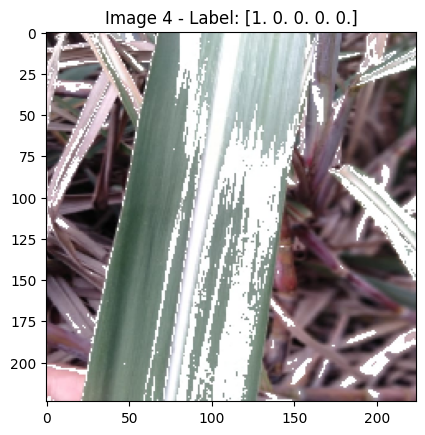

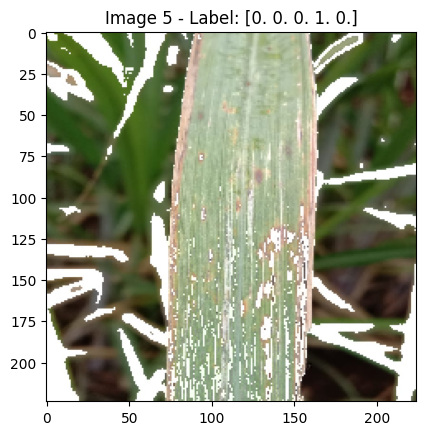

In [4]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(val_set)

# Output the first five images
for i in range(5):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


In [5]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Add
from keras.models import Model
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

def ResNetBlock(inputs, channels, down_sample=False):
    strides = [2, 1] if down_sample else [1, 1]

    conv1 = Conv2D(channels, (3, 3), strides=strides[0], padding="same", activation="relu")(inputs)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(channels, (3, 3), strides=strides[1], padding="same", activation="relu")(bn1)
    bn2 = BatchNormalization()(conv2)

    if down_sample:
        res_conv = Conv2D(channels, (1, 1), strides=strides[0], padding="same", activation="relu")(inputs)
        res_bn = BatchNormalization()(res_conv)
        res = res_bn
    else:
        res = inputs

    x = Add()([bn2, res])
    out = tf.nn.relu(x)
    return out

def ResNet18(hp):
    input_shape = (224, 224, 3)
    num_classes = 5
    
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(bn1)

    res1_1 = ResNetBlock(pool1, 64)
    res1_2 = ResNetBlock(res1_1, 64)
    res2_1 = ResNetBlock(res1_2, 128, down_sample=True)
    res2_2 = ResNetBlock(res2_1, 128)
    
    filters_stage1 = hp.Choice('filters_stage1', values=[128, 256, 512])
    res3_1 = ResNetBlock(res2_2, filters_stage1, down_sample=True)
    res3_2 = ResNetBlock(res3_1, filters_stage1)
    
    filters_stage2 = hp.Choice('filters_stage2', values=[256, 512, 1024])
    res4_1 = ResNetBlock(res3_2, filters_stage2, down_sample=True)
    res4_2 = ResNetBlock(res4_1, filters_stage2)

    avg_pool = GlobalAveragePooling2D()(res4_2)
    fc = Dense(num_classes, activation="softmax")(avg_pool)

    model = Model(inputs=inputs, outputs=fc)
    
    # Specify the learning rate as a hyperparameter
    lr = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2], default=1e-3)

    # Create the optimizer with the chosen learning rate
    optimizer = Adam(learning_rate=lr)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

C:\Users\Jerico\AppData\Local\Temp\ipykernel_22296\1629308786.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Define the Bayesian Optimization tuner
tunerA = BayesianOptimization(
    ResNet18,
    objective='val_loss',
    max_trials=100,  # You can adjust this based on your requirements
    num_initial_points=5,  # Number of initial random trials
    hyperparameters=HyperParameters(),
    directory='my_dir',
    project_name='resnet'
)

# Early stopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Start the search for the best hyperparameters
tunerA.search(train_set, epochs=100, validation_data=val_set, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hpsA = tunerA.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# Build the model with the best hyperparameters
modelA = ResNet18(best_hpsA)
modelA.summary()

# Print the best hyperparameters
print(best_hpsA)


Trial 23 Complete [00h 04m 08s]
val_loss: 3.1198105812072754

Best val_loss So Far: 0.9056015014648438
Total elapsed time: 01h 21m 54s

Search: Running Trial #24

Value             |Best Value So Far |Hyperparameter
512               |512               |filters_stage1
256               |256               |filters_stage2
0.01              |0.01              |learning_rate



c:\Users\Jerico\anaconda3\envs\gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 1/100
58/58 [==============================] - 25s 402ms/step - loss: 1.8607 - accuracy: 0.2965 - val_loss: 17809.3652 - val_accuracy: 0.2000
Epoch 2/100
58/58 [==============================] - 22s 382ms/step - loss: 1.3859 - accuracy: 0.4271 - val_loss: 70.6922 - val_accuracy: 0.2000
Epoch 3/100
58/58 [==============================] - 19s 330ms/step - loss: 1.2323 - accuracy: 0.5095 - val_loss: 2.8221 - val_accuracy: 0.3355
Epoch 4/100
46/58 [======================>.......] - ETA: 3s - loss: 1.1038 - accuracy: 0.5743

KeyboardInterrupt: 

In [ ]:
# CALLBACKS
%load_ext tensorboard
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = EarlyStopping(monitor='val_loss',
                                       patience=5,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = ModelCheckpoint(f'ResNet-{datetime.datetime.now().__format__("%Y-%m-%d-%H-%M-%S")}.h5',
                                         monitor='val_loss',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

#Tensorboard
current_time = datetime.datetime.now().__format__('%Y-%m-%d-%H-%M-%S')
tb_callback = TensorBoard(log_dir=f"./logs/ResNet-{current_time}", histogram_freq=2)

In [ ]:


# Record the start time
start_time = time.time()

# Your existing code for model compilation and training
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_history = resnet_model.fit(
    train_set,
    batch_size=32,
    validation_data = val_set,
    # steps_per_epoch = EPOCH_STEPS,
    epochs=30,
    verbose =1,
    
    callbacks=[lr_reduce, checkpoint, tb_callback, early_stop]
)

# Record the end time
end_time = time.time()

# Calculate and print the total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch 1/30
58/58 [==============================] - ETA: 0s - loss: 1.6156 - accuracy: 0.4141
Epoch 1: val_loss improved from -inf to 16.21350, saving model to GoogleNet-modelv1-2024-01-07-09-38-37.h5
58/58 [==============================] - 29s 403ms/step - loss: 1.6156 - accuracy: 0.4141 - val_loss: 16.2135 - val_accuracy: 0.1914 - lr: 0.0010
Epoch 2/30
52/58 [=========================>....] - ETA: 1s - loss: 1.1815 - accuracy: 0.5463

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'train_history'

# Plot the training loss
plt.plot(train_history.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(train_history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'train_history' is not defined

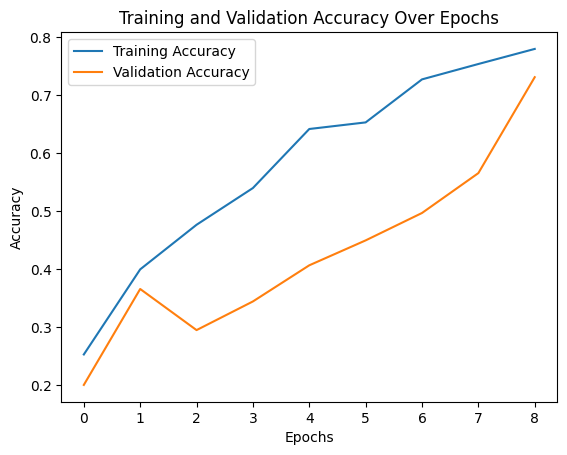

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'train_history'

# Plot the training accuracy
plt.plot(train_history.history['main_accuracy'], label='Training Accuracy')

# Plot the validation accuracy
plt.plot(train_history.history['val_main_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the true labels and predicted labels for the test set
true_labels = test_set.classes

# Ensure that model.predict returns a NumPy array
predicted_probs = model.predict(test_set)
if isinstance(predicted_probs, list):
    # Concatenate the predictions from multiple branches (assuming main branch is the first)
    predicted_probs = np.concatenate(predicted_probs, axis=1)

# Convert predicted probabilities to class indices
predicted_labels = predicted_probs.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'test_set' is not defined

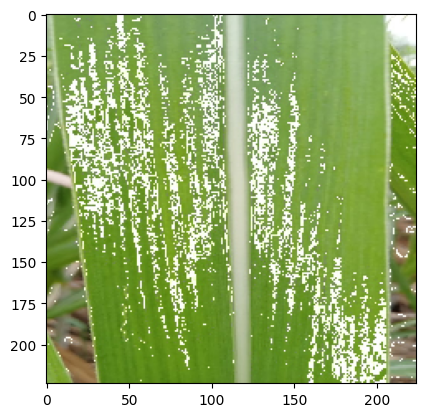

In [ ]:
import matplotlib.pyplot as plt

# Display the first image in the batch
plt.imshow(images[0])
plt.show()


# Constraints

In [ ]:
# Extract a batch of images from your dataset
images, _ = next(val_set)

# Measure inference time for making predictions
start_time = time.time()

# Assuming your model is named 'model' and you want predictions for the batch of images
predictions = model.predict(images)

end_time = time.time()

# Calculate and print the inference time
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

Inference Time: 0.3954 seconds


In [ ]:
def get_model_size(model):
    # Save the model to a temporary file
    model.save('temp_model.h5')

    # Get the size of the saved model file
    model_size = os.path.getsize('temp_model.h5')

    # Remove the temporary file
    os.remove('temp_model.h5')

    return model_size

# Load your model
model = tf.keras.models.load_model(r'D:\New_Fourth_Year\projectDesignGit\sugarcaneSeverityLevel\GoogleNet-modelv1-2024-01-06-22-44-14.h5')

# Get the size of the model
model_size_bytes = get_model_size(model)

# Convert bytes to megabytes for better readability
model_size_megabytes = model_size_bytes / (1024 * 1024)

print(f"Model Size: {model_size_megabytes:.2f} MB")


Model Size: 85.51 MB


In [ ]:
model = tf.keras.models.load_model(r'D:\New_Fourth_Year\projectDesignGit\sugarcaneSeverityLevel\GoogleNet-modelv1-2024-01-06-22-44-14.h5')
# Assuming you have a test set generator
test_set = val_set  # Define or load your test set generator

# Use model.evaluate to get accuracy and other metrics
results = model.evaluate(test_set, verbose=1)  # Set verbose=1 for more information

# 'results' is a list containing the evaluation metrics
accuracy = results[1]  # Index 1 corresponds to the accuracy

# Compute misclassification rate
misclassification_rate = 1 - accuracy

print(f'Misclassification Rate: {misclassification_rate * 100:.2f}%')



15/15 [==============================] - 2s 130ms/step - loss: 5.9283 - main_loss: 2.0294 - aux1_loss: 1.7953 - aux2_loss: 2.1036 - main_accuracy: 0.3441 - aux1_accuracy: 0.3527 - aux2_accuracy: 0.3398
Misclassification Rate: -102.94%


In [ ]:
# 'results' is a list containing the evaluation metrics
main_accuracy = results[4]  # Index 4 corresponds to the accuracy of the main branch

print(f'Main Branch Accuracy: {main_accuracy:.2%}')


Main Branch Accuracy: 34.41%


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have the true labels and predicted labels for the test set
true_labels = test_set.classes

# Ensure that model.predict returns a NumPy array
predicted_probs = model.predict(test_set)
if isinstance(predicted_probs, list):
    # Concatenate the predictions from multiple branches (assuming main branch is the first)
    predicted_probs = np.concatenate(predicted_probs, axis=1)

# Convert predicted probabilities to class labels
predicted_labels = predicted_probs.argmax(axis=1)

# Compute accuracy using sklearn's accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute misclassification rate
misclassification_rate = 1 - accuracy

print(f'Misclassification Rate: {misclassification_rate:.2%}')


170/170 [==============================] - 6s 33ms/step
Misclassification Rate: 96.31%


In [ ]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [ ]:
model_h5_path = r'D:\New_Fourth_Year\projectDesignGit\sugarcaneSeverityLevel\GoogleNet-modelv1-2024-01-06-22-44-14.h5'
# Get and print the FLOPs
flops = get_flops(model_h5_path)
print(f"Number of FLOPs: {flops}")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Number of FLOPs: 7415059
